In [1]:
"""
assumtions for card orientation and blood_spot location on card

areas of improvement

left to right labels 
"""

'\nassumtions for card orientation and blood_spot location on card\n\nareas of improvement\n\nleft to right labels \n'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import imutils
import os
import math
import sys
import shapely
from shapely.geometry import LineString, Point

In [5]:
"""
Preprocessing for blood spot model 
Finds spots on blood spot cards

General steps:

Finding warped image
1. initial resizing/opening
2. converts image to greyscale
3. treshhold picture
4. find contour around card
5. performs transformation on contour around card. This converts the card from general quadrillateral to perfect rectangle.

Finding spots in warped image
6. Resize to set width while preserving aspect ratio
7. Blur image
8. Search through parameters of Hough Circle method in openCV until the 5 spots within the specified height range are found
9. cut out spots

"""
class ScanSpots():

  def __init__(self, directory, pictures, scale_frac = 0.5):
    self.directory = directory
    self.pictures = pictures
    self.scale_frac = scale_frac
    self.opened_pictures = []

    #loop through the pictures in the directory then open and resize them to scale_frac
    for picture in self.pictures:
      #read in
      full_path = self.directory + picture
      base = os.path.basename(full_path)
      print('NAME:' + str(os.path.splitext(base)[0]))
      img = cv2.pyrDown(cv2.imread(full_path, cv2.IMREAD_UNCHANGED))
      # resize 
      width = int(img.shape[1] * self.scale_frac)
      height = int(img.shape[0] * self.scale_frac)
      dim = (width, height)
      img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
      self.opened_pictures.append(img)

  @staticmethod
  def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect
  
  """
  Transforms the contour around card from quadrillateral to perfect rectangle
  """
  @staticmethod
  def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = ScanSpots.order_points(pts)
    (tl, tr, br, bl) = rect
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
      [0, 0],
      [maxWidth - 1, 0],
      [maxWidth - 1, maxHeight - 1],
      [0, maxHeight - 1]], dtype = "float32")
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    # return the warped image
    return warped

  def orderQuadrillateralPoints(self, approx):
    # ordering quadrillateral points from contour for clearity in other methods
    # changing ordering to top left, bottom left, bottom right, top right in that order
    final_approx = approx
    #creating list of x_values and y_values
    X_points = [approx[0,0,0],approx[1,0,0],approx[2,0,0],approx[3,0,0]]
    Y_points = [approx[0,0,1],approx[1,0,1],approx[2,0,1],approx[3,0,1]]

    #looks for the two smallest x values first and adds thier index to a list
    #the coordinates with the 2 smallest x values will be the left side of the contour
    indices = []
    X_points_copy = X_points
    for i in range(0,2):
      min_value = min(X_points_copy)
      min_value_idx = np.where(X_points == min_value)
      X_points_copy = np.delete(X_points_copy,np.where(X_points_copy == min_value))
      indices.append(min_value_idx[0][0])
      
    #between the two coordinates with the smallest x values it finds the one with the smallest y value and assigns it as point 1
    point_1_idx = np.where(Y_points == min([Y_points[i] for i in indices]))[0][0]
    indices.remove(point_1_idx)
    #assigns the leftover coordinate in the 2 smallest x coordinates list to point 2
    point_2_idx = indices[0]

    # goes back to original x values list and creates a list of the two left over x coordinates
    # the coordinates left in the original list are the right side since both of the left side coordinates have been used
    points_3_4 = []
    for i in range(0,4):
      if i != point_1_idx and i != point_2_idx:
        points_3_4.append(i)
    # finds the point with the smallest y-value out of the right side coordinates and assigns that coordinate to point 4
    point_4_idx = np.where(Y_points == min([Y_points[i] for i in points_3_4]))[0][0]
    points_3_4.remove(point_4_idx)
    # last value must be point 3
    point_3_idx = points_3_4[0]

    final_approx = np.array([[approx[point_1_idx,0]],[approx[point_2_idx,0]],[approx[point_3_idx,0]],[approx[point_4_idx,0]]])
    return final_approx

  
  """
  If a card is cut off in its picture then the card is no longer a quadrillateral.
  This method takes the angle of the top side of the card and uses it to create a new bottom side with the same angle.
  This helps preserve the shape of the spots after transformation.

  ERROR: assumes the card is facing upward
  """
  def check_quadrillateral_vectors(self, four_corners, force=False):
    four_corners = self.orderQuadrillateralPoints(four_corners)
    four_corners_final = four_corners
    #defining edge of contour vectors
    vector_top = [four_corners[3][0][0]-four_corners[0][0][0], four_corners[3][0][1]-four_corners[0][0][1]]
    vector_bottom = [four_corners[2][0][0]-four_corners[1][0][0], four_corners[2][0][1]-four_corners[1][0][1]]
    vector_left = LineString([(four_corners[0,0,0], four_corners[0,0,1]), (four_corners[1,0,0], four_corners[1,0,1])])
    vector_right = LineString([(four_corners[3,0,0], four_corners[3,0,1]), (four_corners[2,0,0], four_corners[2,0,1])])


    #using the actan of the vector components to find angle 
    angle_top = math.atan(vector_top[1]/vector_top[0])*(180/math.pi)
    angle_bottom = math.atan(vector_bottom[1]/vector_bottom[0])*(180/math.pi)

    #if angle difference of top and bottom vectors are too big then drop the top vector down to the lowest point it can go
    if abs(angle_bottom-angle_top) > 5 or force == True:
      if angle_top > 0:
        #creating a new vector based on the direction of the top vector then scaling it to be longer
        new_vector = ((four_corners[2][0][0]-vector_top[0])), ((four_corners[2][0][1]-vector_top[1]))
        vector_bottom2 = LineString([new_vector, (four_corners[2,0,0], four_corners[2,0,1])])
        vector_bottom2 = shapely.affinity.scale(vector_bottom2, xfact=2,yfact=2)
        #finding intersection between new vector and the left vector because the vector angle is positive
        new_point = vector_bottom2.intersection(vector_left)
        four_corners_final[1] = [int(new_point.x), int(new_point.y)]
      elif angle_top < 0:
        #creating a new vector based on the direction of the top vector then scaling it to be longer
        new_vector = ((four_corners[1][0][0]+vector_top[0])), ((four_corners[1][0][1]+vector_top[1]))
        vector_bottom2 = LineString([new_vector, (four_corners[1,0,0], four_corners[1,0,1])])
        vector_bottom2 = shapely.affinity.scale(vector_bottom2, xfact=5,yfact=5)
        #finding intersection between new vector and the right vector because the vector angle is negative
        new_point = vector_bottom2.intersection(vector_right)
        four_corners_final[2] = [int(new_point.x), int(new_point.y)]
      else:
        return four_corners
    
    return four_corners_final
  """
  Uses Hough Circle to find the outline of each individual spot.
  The method is unreliable at finding the spots so it searches through a range of parameters until conditions for the rights circles are met.
  The conditions to exit the search are 5 spots are present and those spots are within a specific height range.
  """
  def circle_search(self, image, grayscale_image):
    # Search for good parameter
    #Grid search for circles within a criteria
    for param2_value in range(10,90,10):
      for param1_value in range(40, 120,10):
        correct_spots = []
        #uses the blurred grayscale image to find circles
        circles = cv2.HoughCircles(grayscale_image,cv2.HOUGH_GRADIENT,1,50, param1=param1_value,param2=param2_value,minRadius=10,maxRadius=30)       
        if isinstance(circles,type(None)):
          continue
        #looks for centers of circles between where the blood spots should be
        for circle in circles[0]:
          if circle[1] > 130 and circle[1] < 170:
            correct_spots.append(list(circle))
        if len(correct_spots) == 5:
          return correct_spots
    if isinstance(circles,type(None)):
      circles = [[]]
    if len(circles[0]) != 5:
      circles = None
    return circles
  """
  Finds the contour around the card by finding the contour that has the greatest area.
  """
  def findQuadrillateral(self, threshed_img):

    # find contours and get the external one
    contours, _ = cv2.findContours(threshed_img.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # threshed_img_draw =  cv2.drawContours(threshed_img, contours, -1, (255, 255, 0), 1)
    # find contour with max area
    max_contour = max(contours, key=lambda x: cv2.contourArea(x))
    # draw max contour over image
    # thresh_max =  cv2.drawContours(img, [max_contour], -1, (255, 255, 0), 1)
    # simplify contours
    epsilon = 0.01*cv2.arcLength(max_contour,True)
    approx = cv2.approxPolyDP(max_contour,epsilon,True)

    #check if contour is a quadrillateral
    if len(approx)==4:
      failed = False
      #checks to see if the top line of the contour is similar to the bottom line and if not moves the top line down
      approx = self.check_quadrillateral_vectors(approx)
      return approx, failed
    else:
      print("Failed to find quadralateral!!!!")
      failed = True
      return approx, failed

  def resizeWarpedImage(self, warped, new_width):
      height, width, _ = warped.shape
      height = int((new_width/width) * height)
      dim = (new_width, height)
      # Resizing warped pictures to predetermined with while preserving aspect ratio (SOURCE OF ERROR)
      print('original: '+str(warped.shape)+'\nresized to: '+str(dim[1])+', '+str(dim[0]))
      warped = cv2.resize(warped, dim, interpolation = cv2.INTER_AREA)
      return warped

  def findSpots(self):
    contour_points = []
    warped_imgs = []
    imgs_with_contours = []
    cut_out_imgs = []
    for img in self.opened_pictures:
      
      #grayscale image
      img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)[:,:,0] # convert to hsv and select off h channel
      img_gray = 255 * (img_gray / img_gray.max()) # rescale to range 0 to 255 to max out brightness
      # apply a binary threshold
      _, threshed_img = cv2.threshold(img_gray, 35, 255, cv2.THRESH_BINARY)
      # find the contour of the card
      approx, failed = self.findQuadrillateral(threshed_img)
      #draw contour around card
      img_with_contour = cv2.drawContours(img, [approx], 0, (0,0,255), 3)
      #formatting coordinates for skew transform
      points = [tuple(coordinates[0]) for coordinates in approx]
      points = np.array(points)
      # skew transform
      warped = self.four_point_transform(img, points)
      #resizing warped image to have width of 
      width = 325 ##DO NOT CHANGE FROM 325 (changing will affect circle radius parameters)
      warped = self.resizeWarpedImage(warped, width)
      #blur image 9 times (needed to find the circles because the spots are dotted lines)
      blurred_image = cv2.medianBlur(warped,9)
      # Convert to greyscale
      blurred_image = cv2.cvtColor(blurred_image,cv2.COLOR_BGR2GRAY)
      circles = self.circle_search(warped, blurred_image)

      #Drawing and cutting out circles if found
      try:
        if not failed:
          circles = np.uint16(np.around(circles))
          copy = warped.copy()
          #Cut out circles
          cut_outs = []
          for circle in circles:
            cut_outs.append(copy[circle[1]-25:circle[1]+25,circle[0]-25:circle[0]+25])

          # Draw the circles
          for i in circles:
            # draw the outer circle
            cv2.circle(warped,(i[0],i[1]),i[2],(0,255,0),2)
            # draw the center of the circle
            cv2.circle(warped,(i[0],i[1]),2,(0,0,255),3)

      except:
        print("no circles found")
        cut_outs = None 

      warped_imgs.append(warped)
      imgs_with_contours.append(img_with_contour)
      cut_out_imgs.append(cut_outs)

    return warped_imgs, imgs_with_contours, cut_out_imgs
  

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


NAME:8DF6261F-E2A0-45B4-9B93-49F8707F5970
original: (691, 255, 3)
resized to: 880, 325


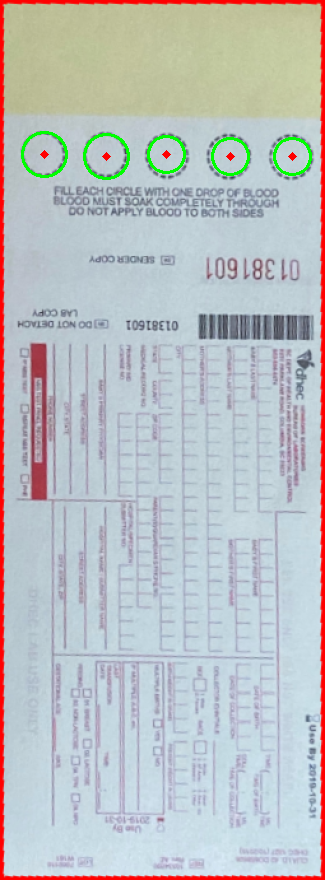

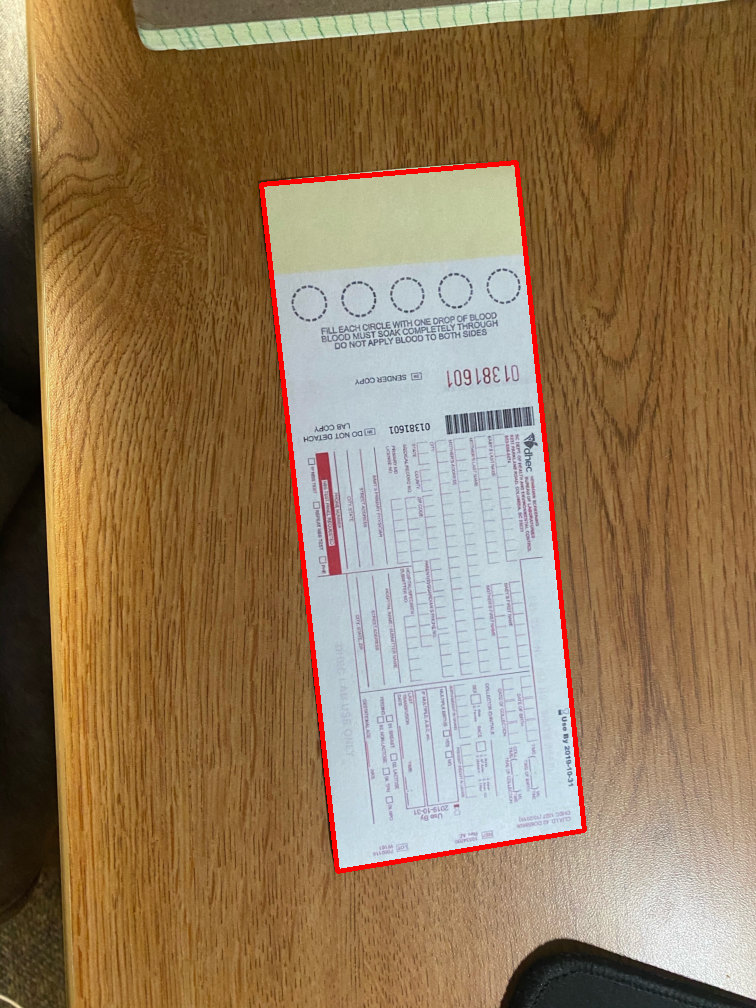

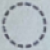

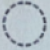

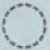

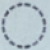

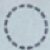

In [10]:
path_head = "/content/drive/MyDrive/Blood Spot/Images/Pictures_of_blood_spot_cards_for_transformations"
pictures = ["/8DF6261F-E2A0-45B4-9B93-49F8707F5970.jpeg"]
            #"/hard_crop_mirrored.png", "/hard_crop.png"]
            # "/344C2F59-5A1E-4D83-A8CF-B3AC8D34983A.jpeg",
            # "/3885EF9E-031D-43C2-BC44-C72A03B399E2.jpeg",
            # "/817DCBF8-E844-413C-88EB-C0009A32F3DC.jpeg",
            # "/8DF6261F-E2A0-45B4-9B93-49F8707F5970.jpeg",
            # "/B8C51D90-DBEF-45ED-97E5-ECC1986E70F5.jpeg"]

spots = ScanSpots(directory=path_head, pictures=pictures)
warped_imgs, imgs_with_contours, cut_outs_imgs = spots.findSpots()
for i in range(0,len(warped_imgs)):
  cv2_imshow(warped_imgs[i])
  cv2_imshow(imgs_with_contours[i])
  for img in cut_outs_imgs[i]:
    cv2_imshow(img)